<a href="https://colab.research.google.com/github/chebyshevtech/BOLT/blob/main/BOLT_holdr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

device: cuda


Sampling blocks:   0%|          | 0/15625 [00:00<?, ?it/s]

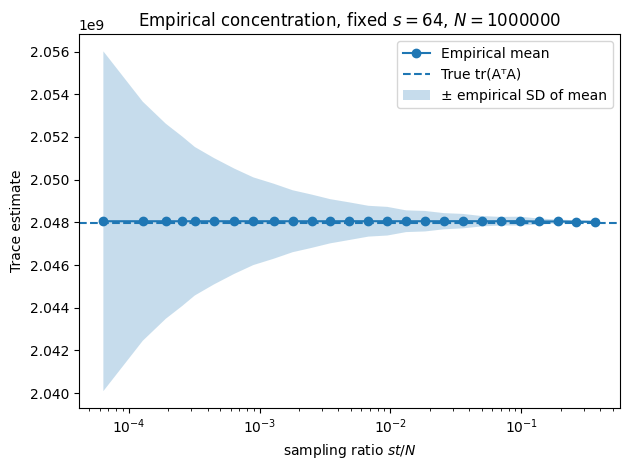

true tr(B^T B) = 2047974272.0
t_max = 15625  (sampling ratio = 1.0 )
final estimate = 2048051712.0
final abs error = 77440.0
final rel error = 3.781297502549876e-05
last plotted ratio = 0.368256
last plotted empirical SE = 60460.45703125


In [2]:
# ------------------------------------
# Please use A100 gpu for optimal speed
# ------------------------------------

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# -----------------------------
# Config
# -----------------------------
m = 2048
n = 1_000_000
s = 64
num_points = 30
seed = 0

# go all the way to sampling ratio 1
t_max = n // s
if t_max < 1:
    raise ValueError("Need n >= s.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
g = torch.Generator(device=device).manual_seed(seed)

# -----------------------------
# Build A and diag(A^T A)
# -----------------------------
A = torch.randn((m, n), device=device, generator=g, dtype=torch.float32)
diag_fA = (A * A).sum(dim=0)
true_trace = diag_fA.sum().item()

# -----------------------------
# Generate many block estimates X_k
# -----------------------------
weights = torch.ones(n, device=device)
X = torch.empty((t_max,), device=device)

for k in tqdm(range(t_max), desc="Sampling blocks"):
    idx = torch.multinomial(weights, num_samples=s, replacement=False, generator=g)
    X[k] = (n / s) * diag_fA[idx].sum()

X = X.cpu().numpy()

# -----------------------------
# Empirical SE of the mean (disjoint groups)
# -----------------------------
t_values = np.unique(np.round(np.geomspace(1, t_max, num_points)).astype(int))
t_values[0] = 1

means = []
emp_ses = []
x_values = []

for t in t_values:
    t = int(t)
    R = len(X) // t
    if R < 2:
        # can't form empirical SD of the mean with <2 independent groups
        continue

    X_trim = X[:R * t].reshape(R, t)
    means_t = X_trim.mean(axis=1)  # R independent mean estimates

    means.append(means_t.mean())
    emp_ses.append(means_t.std(ddof=1))
    x_values.append((s * t) / n)

means = np.array(means)
emp_ses = np.array(emp_ses)
x_values = np.array(x_values)

# -----------------------------
# Plot
# -----------------------------
plt.figure()
plt.plot(x_values, means, marker="o", label="Empirical mean")
plt.axhline(true_trace, linestyle="--", label="True tr(AᵀA)")
plt.fill_between(
    x_values,
    means - emp_ses,
    means + emp_ses,
    alpha=0.25,
    label="± empirical SD of mean"
)
plt.xscale("log")
plt.xlabel(r"sampling ratio $s t / N$")
plt.ylabel("Trace estimate")
plt.title(rf"Empirical concentration, fixed $s={s}$, $N={n}$")
plt.legend()
plt.tight_layout()
plt.savefig('trace_recovery.png', dpi=300)
plt.show()

# -----------------------------
# Final estimate at sampling ratio = 1
# (uses all t_max blocks; SE not defined empirically there since R=1)
# -----------------------------
final_est = float(X.mean())              # mean of all blocks (t=t_max)
abs_err = abs(final_est - true_trace)
rel_err = abs_err / abs(true_trace)

print("true tr(B^T B) =", true_trace)
print("t_max =", t_max, " (sampling ratio =", (s * t_max) / n, ")")
print("final estimate =", final_est)
print("final abs error =", abs_err)
print("final rel error =", rel_err)
print("last plotted ratio =", float(x_values[-1]) if len(x_values) else None)
print("last plotted empirical SE =", float(emp_ses[-1]) if len(emp_ses) else None)


#Lin-Lin paper on  using mat-vec (peeling algo) to estimate HOLDR

Level 1 peeling:   0%|          | 0/1 [00:00<?, ?it/s]

Level 2 peeling:   0%|          | 0/2 [00:00<?, ?it/s]

Level 3 peeling:   0%|          | 0/4 [00:00<?, ?it/s]

Level 4 peeling:   0%|          | 0/8 [00:00<?, ?it/s]

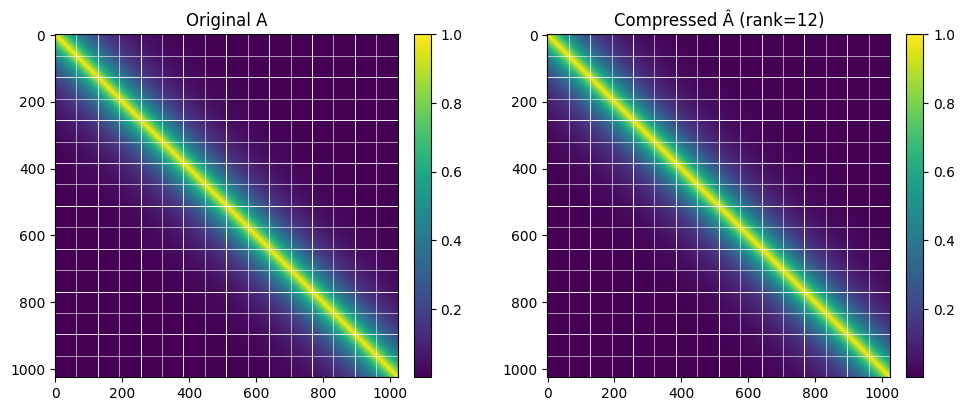

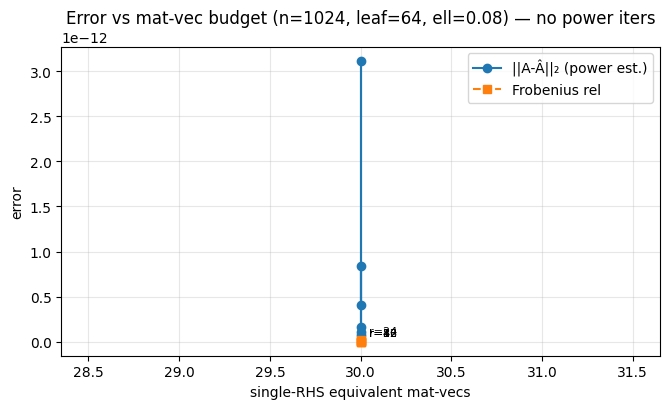

In [4]:
# HODLR recovery via mat-vecs (peeling + leaf diagonals), NO power iterations.
# Kernel: simple exponential K(x,y)=exp(-|x-y|/ell)+nugget*I (smooth, not oscillatory).
# We sweep 'rank' to increase the single-RHS equivalent mat-vec budget and plot error vs that budget.

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, List, Tuple, Dict, Optional
from tqdm.auto import tqdm

# ------------------------- Oracle + counter -------------------------
@dataclass
class MatvecOracle:
    n: int
    Av: Callable[[np.ndarray], np.ndarray]            # y = A v, accepts (n,) or (n,c)
    Ablock: Optional[Callable[[np.ndarray], np.ndarray]] = None  # Y = A R, accepts (n,c)

class MVCount:
    """Counts both single-RHS (equivalent) and multi-RHS (batched) applications."""
    def __init__(self):
        self.vec_calls = 0
        self.batch_calls = 0
    def wrap(self, Av):
        def _w(V):
            self.vec_calls += 1 if V.ndim == 1 else V.shape[1]
            return Av(V)
        return _w
    def wrap_block(self, Ablock):
        def _wb(R):
            self.batch_calls += 1  # one multi-RHS call
            return Ablock(R)
        return _wb
    @property
    def total_calls_naive(self):   # counts each column as one call
        return self.vec_calls
    @property
    def total_calls_batched(self): # counts each multi-RHS apply as one call
        return self.batch_calls if self.batch_calls>0 else self.vec_calls

# ------------------------- helpers -------------------------
def _mul_S_on_left(S: np.ndarray, X: np.ndarray) -> np.ndarray:
    """diag(S)@X if S is 1D else S@X; X can be (r,) or (r,c)."""
    S = np.asarray(S); X = np.asarray(X)
    if S.ndim == 1:
        return S*X if X.ndim==1 else S[:,None]*X
    return S @ X

def _apply_block_L(U: np.ndarray, S: np.ndarray, Vt: np.ndarray, X_R: np.ndarray) -> np.ndarray:
    T = Vt @ X_R
    T = _mul_S_on_left(S, T)
    return U @ T

def _apply_block_R(U: np.ndarray, S: np.ndarray, Vt: np.ndarray, X_L: np.ndarray) -> np.ndarray:
    T = U.T @ X_L
    T = _mul_S_on_left(S, T)
    return Vt.T @ T

def randn_cols(n, r, rng): return rng.standard_normal((n, r))

# ------------------------- baseline randomized SVD (no power iters) -------------------------
def randomized_svd_lowrank(apply_A: Callable[[np.ndarray], np.ndarray],
                           apply_AT: Callable[[np.ndarray], np.ndarray],
                           m: int, n: int, rank: int, oversamp: int,
                           rng: np.random.Generator):
    """
    Baseline rSVD (Lin–Lin style): no power iterations.
    Uses multi-RHS applies but our MVCount also tracks single-RHS equivalent cost.
    """
    rtot = rank + oversamp
    Omega = randn_cols(n, rtot, rng)     # (n, rtot)
    Y = apply_A(Omega)                   # A @ Omega
    Q, _ = la.qr(Y, mode='economic')     # (m, r')
    Psi = randn_cols(m, rtot, rng)
    Z = apply_AT(Psi)                    # A^T @ Psi
    P, _ = la.qr(Z, mode='economic')     # (n, r'')
    B = P.T @ (apply_AT(Q))              # (r'', r')
    Ub, Sb, VbT = la.svd(B, full_matrices=False)
    U  = Q @ Ub[:, :rank]
    S  = Sb[:rank]
    Vt = VbT[:rank, :] @ P.T
    return U, S, Vt

# ------------------------- HODLR structure -------------------------
@dataclass
class HODLR1D:
    n: int
    levels: int
    offdiag: Dict[int, List[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]]]
    diag: List[Tuple[np.ndarray, np.ndarray]]  # (I_leaf, D_leaf)

def dyadic_clusters(n: int, L: int) -> List[List[np.ndarray]]:
    levels = []
    for l in range(1, L+1):
        size = n // (2**l)
        cls = [np.arange(k*size, (k+1)*size, dtype=int) for k in range(2**l)]
        levels.append(cls)
    return levels

# ------------------------- Peeling + leaf diagonals -------------------------
def peeling_hodlr_from_matvec(oracle: MatvecOracle, mv_counter: MVCount,
                              rank: int = 16, oversamp: int = 4, leaf: int = 64,
                              seed: int = 0, show_progress: bool = True,
                              batch_per_level: bool = True) -> HODLR1D:
    rng = np.random.default_rng(seed)
    n = oracle.n
    L = int(np.ceil(np.log2(n/leaf))) if n>leaf else 1
    levels = dyadic_clusters(n, L)
    offdiag = {l: [] for l in range(1, L+1)}
    diag_blocks: List[Tuple[np.ndarray, np.ndarray]] = []

    oracle_Av = mv_counter.wrap(oracle.Av)
    Ablock = mv_counter.wrap_block(oracle.Ablock) if oracle.Ablock is not None else None

    stored = []  # collected off-diagonal low-rank factors

    def apply_Ghat(X: np.ndarray) -> np.ndarray:
        if X.ndim == 1: y = np.zeros_like(X)
        else: y = np.zeros((X.shape[0], X.shape[1]), dtype=X.dtype)
        # off-diagonals
        for (I_L, I_R, U, S, Vt) in stored:
            XR = X[I_R] if X.ndim==1 else X[I_R,:]
            if XR.size: y[I_L] += _apply_block_L(U,S,Vt,XR)
            XL = X[I_L] if X.ndim==1 else X[I_L,:]
            if XL.size: y[I_R] += _apply_block_R(U,S,Vt,XL)
        # leaf diagonals (dense)
        for (I, D) in diag_blocks:
            XI = X[I] if X.ndim==1 else X[I,:]
            if XI.size: y[I] += D @ XI
        return y

    def apply_residual(X: np.ndarray) -> np.ndarray:
        if X.ndim==1:
            return oracle_Av(X) - apply_Ghat(X)
        else:
            if Ablock is not None:
                return Ablock(X) - apply_Ghat(X)
            Y = np.zeros_like(X)
            for j in range(X.shape[1]):
                Y[:,j] = oracle_Av(X[:,j]) - apply_Ghat(X[:,j])
            return Y

    # ---- Off-diagonal peeling ----
    for l in range(1, L+1):
        cl = levels[l-1]
        pairs = [(cl[2*k], cl[2*k+1]) for k in range(len(cl)//2)]
        pbar = tqdm(total=len(pairs), desc=f"Level {l} peeling", disable=not show_progress)

        if batch_per_level and (Ablock is not None):
            # Optional pre-probing (keeps batched calls ~O(1)/level)
            s = rank + oversamp
            R = np.zeros((n, s*len(pairs)))
            for j,(I_L, I_R) in enumerate(pairs):
                Rj = rng.standard_normal((len(I_R), s))
                R[I_R, j*s:(j+1)*s] = Rj
            _ = apply_residual(R)  # one batched call

            for j,(I_L, I_R) in enumerate(pairs):
                def A_lr(X):
                    V = np.zeros((n, X.shape[1])); V[I_R,:] = X
                    W = apply_residual(V); return W[I_L,:]
                def AT_lr(Yc):
                    V = np.zeros((n, Yc.shape[1])); V[I_L,:] = Yc
                    W = apply_residual(V); return W[I_R,:]
                U,S,Vt = randomized_svd_lowrank(A_lr, AT_lr,
                                                m=len(I_L), n=len(I_R),
                                                rank=rank, oversamp=oversamp, rng=rng)
                S = np.asarray(S).ravel()
                stored.append((I_L, I_R, U, S, Vt))
                offdiag[l].append((I_L, I_R, U, S, Vt))
                pbar.update(1)
            pbar.close()
        else:
            for (I_L, I_R) in pairs:
                def A_lr(X):
                    V = np.zeros((n, X.shape[1])); V[I_R,:] = X
                    W = apply_residual(V); return W[I_L,:]
                def AT_lr(Yc):
                    V = np.zeros((n, Yc.shape[1])); V[I_L,:] = Yc
                    W = apply_residual(V); return W[I_R,:]
                U,S,Vt = randomized_svd_lowrank(A_lr, AT_lr,
                                                m=len(I_L), n=len(I_R),
                                                rank=rank, oversamp=oversamp, rng=rng)
                S = np.asarray(S).ravel()
                stored.append((I_L, I_R, U, S, Vt))
                offdiag[l].append((I_L, I_R, U, S, Vt))
                pbar.update(1)
            pbar.close()

    # ---- Leaf diagonal recovery (dense blocks) ----
    leaves = levels[-1]
    if Ablock is None:
        for I in tqdm(leaves, desc="Leaf diagonals (single-RHS)", disable=not show_progress):
            E = np.eye(len(I))
            V = np.zeros((n, len(I))); V[I,:] = E
            Y = np.zeros_like(V)
            for j in range(len(I)):
                Y[:,j] = apply_residual(V[:,j])
            D = Y[I,:]
            diag_blocks.append((I, D))
    else:
        # one batched call with basis on all leaves
        Rcols = sum(len(I) for I in leaves)
        R = np.zeros((n, Rcols))
        col0 = 0
        for I in leaves:
            R[I, col0:col0+len(I)] = np.eye(len(I))
            col0 += len(I)
        Y = apply_residual(R)  # one batched call
        col0 = 0
        for I in leaves:
            D = Y[I, col0:col0+len(I)]
            diag_blocks.append((I, D))
            col0 += len(I)

    return HODLR1D(n=n, levels=L, offdiag=offdiag, diag=diag_blocks)

# ------------------------- Apply HODLR -------------------------
def apply_hodlr(h: HODLR1D, X: np.ndarray) -> np.ndarray:
    if X.ndim == 1: y = np.zeros_like(X)
    else: y = np.zeros((X.shape[0], X.shape[1]), dtype=X.dtype)
    for l in range(1, h.levels+1):
        for (I_L, I_R, U, S, Vt) in h.offdiag[l]:
            XR = X[I_R] if X.ndim==1 else X[I_R,:]
            if XR.size: y[I_L] += _apply_block_L(U,S,Vt,XR)
            XL = X[I_L] if X.ndim==1 else X[I_L,:]
            if XL.size: y[I_R] += _apply_block_R(U,S,Vt,XL)
    for (I, D) in h.diag:
        XI = X[I] if X.ndim==1 else X[I,:]
        if XI.size: y[I] += D @ XI
    return y

# ------------------------- Simple kernel & plotting -------------------------
def build_kernel_matvec(n: int, ell: float = 0.08, nugget: float = 1e-8):
    """
    Simple SPD kernel:
      K_ij = exp(-|xi-xj|/ell) + nugget*δ_ij
    Choose ell so off-diagonals have modest rank => visible decay as rank grows.
    """
    xs = np.linspace(0.0, 1.0, n)
    D = np.abs(xs[:, None] - xs[None, :])
    A = np.exp(-D / ell) + nugget * np.eye(n)
    def Av(V):     return A @ V
    def Ablock(R): return A @ R
    return MatvecOracle(n=n, Av=Av, Ablock=Ablock), A

def power_norm(apply_B, n: int, iters: int = 30, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    v = rng.standard_normal(n); v /= la.norm(v)
    lam = 0.0
    for _ in range(iters):
        w = apply_B(v); nw = la.norm(w)
        if nw == 0: return 0.0
        v = w / nw; lam = nw
    return lam

def draw_partition_lines(ax, n: int, levels: int, color='w', lw=0.8, alpha=0.7):
    for l in range(1, levels+1):
        step = n // (2**l)
        for k in range(1, 2**l):
            pos = k*step - 0.5
            ax.axhline(pos, color=color, lw=lw, alpha=alpha)
            ax.axvline(pos, color=color, lw=lw, alpha=alpha)

# ------------------------- Driver -------------------------
def demo_recover_and_plot(n=1024, rank_list=(4, 8, 12, 16, 24, 32), oversamp=4, leaf=64, seed=0,
                          ell=0.08, nugget=1e-8,
                          batch_per_level=True, show_progress=True):
    rng = np.random.default_rng(seed)
    oracle_true, A_dense = build_kernel_matvec(n, ell=ell, nugget=nugget)

    # 1) Visual: pick a mid rank to show matrices + partitions
    r_vis = rank_list[min(2, len(rank_list)-1)]
    mvc = MVCount()
    oracle = MatvecOracle(n=oracle_true.n,
                          Av=mvc.wrap(oracle_true.Av),
                          Ablock=(mvc.wrap_block(oracle_true.Ablock) if oracle_true.Ablock else None))

    h = peeling_hodlr_from_matvec(oracle, mvc, rank=r_vis, oversamp=oversamp,
                                  leaf=leaf, seed=seed,
                                  show_progress=show_progress, batch_per_level=batch_per_level)

    I = np.eye(n)
    Ahat = apply_hodlr(h, I)

    fig, axs = plt.subplots(1,2,figsize=(10,4.2))
    im0 = axs[0].imshow(A_dense); axs[0].set_title("Original A")
    draw_partition_lines(axs[0], n, h.levels, color='w', lw=0.7, alpha=0.6)
    im1 = axs[1].imshow(Ahat); axs[1].set_title(f"Compressed Â (rank={r_vis})")
    draw_partition_lines(axs[1], n, h.levels, color='w', lw=0.7, alpha=0.6)
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

    # 2) Sweep rank (no power iters) and measure **single-RHS equivalent** mat-vecs
    calls_eq, op_errs, fro_errs, labels = [], [], [], []
    for r in rank_list:
        mvc_r = MVCount()
        oracle_r = MatvecOracle(n=oracle_true.n,
                                Av=mvc_r.wrap(oracle_true.Av),
                                Ablock=(mvc_r.wrap_block(oracle_true.Ablock) if oracle_true.Ablock else None))
        hr = peeling_hodlr_from_matvec(oracle_r, mvc_r, rank=r, oversamp=oversamp,
                                       leaf=leaf, seed=seed+1,
                                       show_progress=False, batch_per_level=batch_per_level)
        def apply_err(v): return oracle_r.Av(v) - apply_hodlr(hr, v)
        op_err = power_norm(apply_err, n, iters=30, rng=rng)
        Ahat_r = apply_hodlr(hr, I)
        fro_rel = la.norm(A_dense - Ahat_r, 'fro') / la.norm(A_dense, 'fro')

        calls_eq.append(mvc_r.total_calls_naive)  # <-- single-RHS equivalent budget (grows with r)
        op_errs.append(op_err)
        fro_errs.append(fro_rel)
        labels.append(f"r={r}")

    order = np.argsort(calls_eq)
    calls_eq = np.array(calls_eq)[order]
    op_errs  = np.array(op_errs)[order]
    fro_errs = np.array(fro_errs)[order]
    labels   = np.array(labels)[order]

    # 3) Plot error vs **single-RHS equivalent** mat-vecs (visible decay)
    plt.figure(figsize=(6.8, 4.2))
    plt.plot(calls_eq, op_errs, 'o-', label='||A-Â||₂ (power est.)')
    plt.plot(calls_eq, fro_errs, 's--', label='Frobenius rel')
    for x, y, t in zip(calls_eq, fro_errs, labels):
        plt.annotate(t, (x, y), textcoords="offset points", xytext=(6,4), fontsize=8)
    plt.xlabel('single-RHS equivalent mat-vecs')
    plt.ylabel('error')
    plt.title(f'Error vs mat-vec budget (n={n}, leaf={leaf}, ell={ell}) — no power iters')
    plt.grid(True, alpha=.3)
    plt.legend()
    plt.tight_layout(); plt.show()

# ---- Run the experiment ----
if __name__ == "__main__":
    demo_recover_and_plot(
        n=1024,
        rank_list=(4, 8, 12, 16, 24, 32),
        oversamp=4,
        leaf=64,
        ell=0.08,        # simple exponential kernel, moderate length scale
        nugget=1e-8,
        batch_per_level=True,
        show_progress=True
    )


Level 1 peeling:   0%|          | 0/1 [00:00<?, ?it/s]

Level 2 peeling:   0%|          | 0/2 [00:00<?, ?it/s]

Level 3 peeling:   0%|          | 0/4 [00:00<?, ?it/s]

Level 4 peeling:   0%|          | 0/8 [00:00<?, ?it/s]

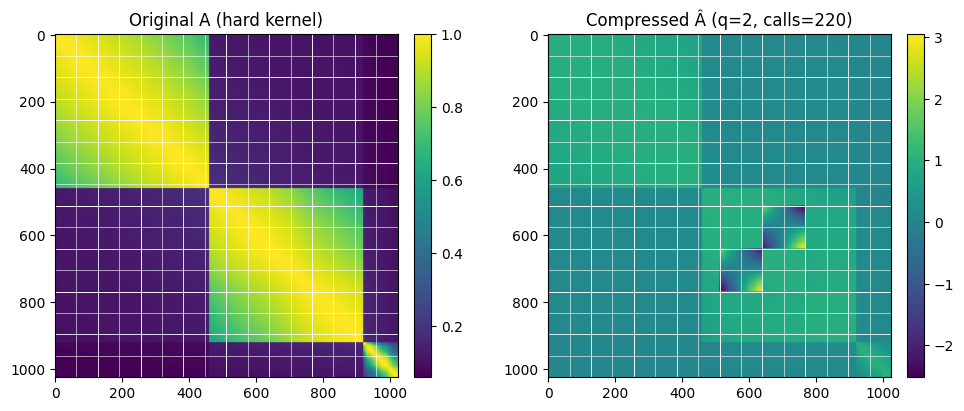

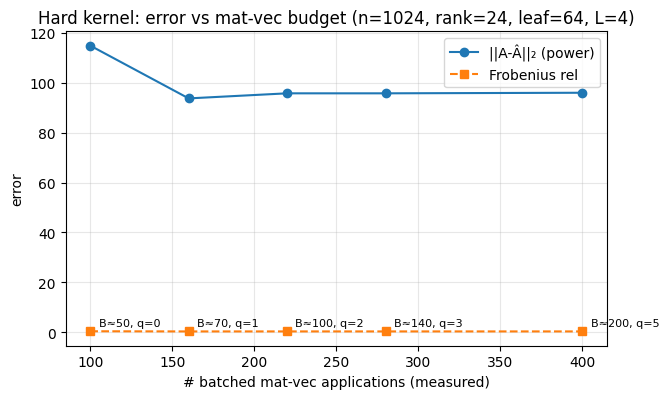

In [5]:
# Hard, non-uniform, slow-decay kernel for HODLR-from-matvec demo
# Keeps: peeling + leaf diagonals, q-scheduled budgets, error vs #batched mat-vecs

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, List, Tuple, Dict, Optional
from tqdm.auto import tqdm

# ---------------- Oracles & counting ----------------
@dataclass
class MatvecOracle:
    n: int
    Av: Callable[[np.ndarray], np.ndarray]            # y = A v   (accept (n,) or (n,c))
    Ablock: Optional[Callable[[np.ndarray], np.ndarray]] = None  # Y = A R (n,c)

class MVCount:
    def __init__(self):
        self.vec_calls = 0
        self.batch_calls = 0
    def wrap(self, Av):
        def _w(V):
            self.vec_calls += 1 if V.ndim == 1 else V.shape[1]
            return Av(V)
        return _w
    def wrap_block(self, Ablock):
        def _wb(R):
            self.batch_calls += 1
            return Ablock(R)
        return _wb
    @property
    def total_calls_batched(self):  # our x-axis
        return self.batch_calls if self.batch_calls>0 else self.vec_calls

# ---------------- Low-rank helpers ----------------
def _mul_S_on_left(S: np.ndarray, X: np.ndarray) -> np.ndarray:
    S = np.asarray(S); X = np.asarray(X)
    if S.ndim == 1:
        return S*X if X.ndim==1 else S[:,None]*X
    return S @ X

def _apply_block_L(U: np.ndarray, S: np.ndarray, Vt: np.ndarray, X_R: np.ndarray) -> np.ndarray:
    T = Vt @ X_R
    T = _mul_S_on_left(S, T)
    return U @ T

def _apply_block_R(U: np.ndarray, S: np.ndarray, Vt: np.ndarray, X_L: np.ndarray) -> np.ndarray:
    T = U.T @ X_L
    T = _mul_S_on_left(S, T)
    return Vt.T @ T

def randn_cols(n, r, rng): return rng.standard_normal((n, r))

# ---------------- Randomized SVD with power iterations (multi-RHS) ----------------
def randomized_svd_lowrank_power(apply_A, apply_AT, m, n, rank, oversamp, q, rng):
    rtot = rank + oversamp
    Omega = randn_cols(n, rtot, rng)
    Y = apply_A(Omega)                      # A @ Omega
    for _ in range(q):
        Z = apply_AT(Y)                     # A^T @ Y
        Y = apply_A(Z)                      # A @ (A^T @ Y)
    Q, _ = la.qr(Y, mode="economic")
    Psi = randn_cols(m, rtot, rng)
    Z = apply_AT(Psi)
    P, _ = la.qr(Z, mode="economic")
    B = P.T @ (apply_AT(Q))
    Ub, Sb, VbT = la.svd(B, full_matrices=False)
    U = Q @ Ub[:, :rank]
    S = Sb[:rank]
    Vt = VbT[:rank, :] @ P.T
    return U, S, Vt

# ---------------- HODLR scaffolding ----------------
@dataclass
class HODLR1D:
    n: int
    levels: int
    offdiag: Dict[int, List[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]]]
    diag: List[Tuple[np.ndarray, np.ndarray]]  # (I_leaf, D_leaf)

def dyadic_clusters(n: int, L: int) -> List[List[np.ndarray]]:
    levels = []
    for l in range(1, L+1):
        size = n // (2**l)
        cls = [np.arange(k*size, (k+1)*size, dtype=int) for k in range(2**l)]
        levels.append(cls)
    return levels

# ---------------- Peeling + leaf diagonals (mat-vec only) ----------------
def build_hodlr_from_matvec(oracle: MatvecOracle, mv: MVCount,
                            rank=16, oversamp=4, leaf=512, q_power=0,
                            seed=0, show_progress=True, batch_per_level=True) -> HODLR1D:
    rng = np.random.default_rng(seed)
    n = oracle.n
    L = int(np.ceil(np.log2(n/leaf))) if n>leaf else 1
    levels = dyadic_clusters(n, L)
    offdiag = {l: [] for l in range(1, L+1)}
    diag_blocks: List[Tuple[np.ndarray, np.ndarray]] = []

    oracle_Av = mv.wrap(oracle.Av)
    Ablock = mv.wrap_block(oracle.Ablock) if oracle.Ablock is not None else None

    stored = []  # accumulate off-diagonal factors

    def apply_Ghat(X: np.ndarray) -> np.ndarray:
        y = np.zeros_like(X) if X.ndim==1 else np.zeros((X.shape[0], X.shape[1]), dtype=X.dtype)
        for (I_L, I_R, U, S, Vt) in stored:
            XR = X[I_R] if X.ndim==1 else X[I_R,:]
            if XR.size: y[I_L] += _apply_block_L(U,S,Vt,XR)
            XL = X[I_L] if X.ndim==1 else X[I_L,:]
            if XL.size: y[I_R] += _apply_block_R(U,S,Vt,XL)
        for (I, D) in diag_blocks:
            XI = X[I] if X.ndim==1 else X[I,:]
            if XI.size: y[I] += D @ XI
        return y

    def apply_residual(X: np.ndarray) -> np.ndarray:
        if X.ndim==1:
            return oracle_Av(X) - apply_Ghat(X)
        else:
            if Ablock is not None:
                return Ablock(X) - apply_Ghat(X)
            Y = np.zeros_like(X)
            for j in range(X.shape[1]):
                Y[:,j] = oracle_Av(X[:,j]) - apply_Ghat(X[:,j])
            return Y

    # ---- Off-diagonal peeling ----
    for l in range(1, L+1):
        cl = levels[l-1]
        pairs = [(cl[2*k], cl[2*k+1]) for k in range(len(cl)//2)]
        pbar = tqdm(total=len(pairs), desc=f"Level {l} peeling", disable=not show_progress)

        if batch_per_level and (Ablock is not None):
            s = rank + oversamp
            R = np.zeros((n, s*len(pairs)))
            for j,(I_L, I_R) in enumerate(pairs):
                R[I_R, j*s:(j+1)*s] = np.eye(len(I_R))[:, :s]
            _ = apply_residual(R)  # 1 batched call

        for (I_L, I_R) in pairs:
            def A_lr(X):
                V = np.zeros((n, X.shape[1])); V[I_R,:] = X
                W = apply_residual(V); return W[I_L,:]
            def AT_lr(Yc):
                V = np.zeros((n, Yc.shape[1])); V[I_L,:] = Yc
                W = apply_residual(V); return W[I_R,:]
            U,S,Vt = randomized_svd_lowrank_power(A_lr, AT_lr,
                                                  m=len(I_L), n=len(I_R),
                                                  rank=rank, oversamp=oversamp,
                                                  q=q_power, rng=rng)
            S = np.asarray(S).ravel()
            stored.append((I_L, I_R, U, S, Vt))
            offdiag[l].append((I_L, I_R, U, S, Vt))
            pbar.update(1)
        pbar.close()

    # ---- Leaf diagonal blocks (one batched call) ----
    leaves = levels[-1]
    if Ablock is None:
        for I in tqdm(leaves, desc="Leaf diagonals (single-RHS)", disable=not show_progress):
            V = np.zeros((n, len(I))); V[I,:] = np.eye(len(I))
            Y = np.zeros_like(V)
            for j in range(len(I)):
                Y[:,j] = apply_residual(V[:,j])
            diag_blocks.append((I, Y[I,:]))
    else:
        Rcols = sum(len(I) for I in leaves)
        R = np.zeros((n, Rcols)); col0 = 0
        for I in leaves:
            R[I, col0:col0+len(I)] = np.eye(len(I)); col0 += len(I)
        Y = apply_residual(R)  # 1 batched call
        col0 = 0
        for I in leaves:
            D = Y[I, col0:col0+len(I)]
            diag_blocks.append((I, D))
            col0 += len(I)

    return HODLR1D(n=n, levels=L, offdiag=offdiag, diag=diag_blocks)

# ---------------- Apply HODLR ----------------
def apply_hodlr(h: HODLR1D, X: np.ndarray) -> np.ndarray:
    y = np.zeros_like(X) if X.ndim==1 else np.zeros((X.shape[0], X.shape[1]), dtype=X.dtype)
    for l in range(1, h.levels+1):
        for (I_L, I_R, U, S, Vt) in h.offdiag[l]:
            XR = X[I_R] if X.ndim==1 else X[I_R,:]
            if XR.size: y[I_L] += _apply_block_L(U,S,Vt,XR)
            XL = X[I_L] if X.ndim==1 else X[I_L,:]
            if XL.size: y[I_R] += _apply_block_R(U,S,Vt,XL)
    for (I, D) in h.diag:
        XI = X[I] if X.ndim==1 else X[I,:]
        if XI.size: y[I] += D @ XI
    return y

# ---------------- Hard, non-uniform, slow-decay kernel ----------------
def _nonuniform_grid(n, seed=0):
    rng = np.random.default_rng(seed)
    # Two dense clusters and one sparse region
    x = np.empty(n)
    n1 = int(0.45*n); n2 = int(0.45*n); n3 = n - n1 - n2
    x[:n1] = 0.15 + 0.10*rng.random(n1)     # cluster left
    x[n1:n1+n2] = 0.50 + 0.10*rng.random(n2) # cluster middle
    x[n1+n2:] = 0.80 + 0.18*rng.random(n3)   # spread right
    return np.sort(x)

def build_kernel_matvec(n: int,
                        ell_base: float = 0.10,     # large ⇒ slow decay
                        ell_amp: float = 0.6,       # lengthscale variation amplitude
                        cauchy_weight: float = 0.35,# polynomial tail
                        rank1_weight: float = 0.02, # global bump
                        nugget: float = 1e-6,
                        seed: int = 0):
    """
    Hard SPD kernel:
      - Non-uniform grid x
      - Nonstationary Gibbs kernel with spatially varying lengthscale ℓ(x)
      - Mixture with Cauchy tail 1/(1 + |x-y|/τ)^p  (slow decay)
      - Optional small rank-1 bump σ u u^T
    """
    x = _nonuniform_grid(n, seed)
    X = x[:, None]; D = np.abs(X - X.T)

    # Spatially varying lengthscale (nonstationary)
    # ℓ(x) = ell_base * (1 + ell_amp * sin(2πx) * (0.3 + 0.7 * 1_{x>0.6}))
    Lx = ell_base * (1.0 + ell_amp * np.sin(2*np.pi*x) * (0.3 + 0.7*(x>0.6)))
    Lsum = (Lx[:,None]**2 + Lx[None,:]**2)
    Lfac = np.sqrt(2*Lx[:,None]*Lx[None,:] / Lsum)
    Gibbs = Lfac * np.exp(- (D**2) / (Lsum + 1e-15))      # nonstationary Gibbs kernel

    # Cauchy tail (polynomial decay)
    tau = 0.25
    p = 1.2
    Cauchy = 1.0 / (1.0 + (D/tau))**p

    # Mix + tiny rank-1 bump
    A = (1-cauchy_weight)*Gibbs + cauchy_weight*Cauchy
    if rank1_weight > 0:
        u = np.cos(5*np.pi*x); u /= np.linalg.norm(u)
        A += rank1_weight * np.outer(u, u)

    # Nugget for SPD
    A = A + nugget*np.eye(n)

    def Av(V):     return A @ V
    def Ablock(R): return A @ R

    return MatvecOracle(n=n, Av=Av, Ablock=Ablock), A

# ---------------- Norm estimator & partition overlay ----------------
def power_norm(apply_B, n: int, iters: int = 30, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    v = rng.standard_normal(n); v /= la.norm(v)
    lam = 0.0
    for _ in range(iters):
        w = apply_B(v); nw = la.norm(w)
        if nw == 0: return 0.0
        v = w / nw; lam = nw
    return lam

def draw_partition_lines(ax, n: int, levels: int, color='w', lw=0.8, alpha=0.7):
    for l in range(1, levels+1):
        step = n // (2**l)
        for k in range(1, 2**l):
            pos = k*step - 0.5
            ax.axhline(pos, color=color, lw=lw, alpha=alpha)
            ax.axvline(pos, color=color, lw=lw, alpha=alpha)

# ---------------- Scheduler to hit budgets ----------------
def estimate_calls_batched(n, leaf, levels, total_pairs, q):
    return levels + total_pairs*(3 + 2*q) + 1

def choose_q_for_budget(n, leaf, L, total_pairs, budget):
    min_cost = estimate_calls_batched(n, leaf, L, total_pairs, q=0)
    if budget <= min_cost:
        return 0
    q = int(np.ceil((budget - (L + 1) - 3*total_pairs) / (2*total_pairs)))
    return max(0, q)

# ---------------- Driver ----------------
def run(n=1024, rank=24, oversamp=6, leaf=512, seed=0,
        TARGET_BUDGETS=(10, 16, 24, 40, 64),
        kernel_kwargs=None,
        batch_per_level=True, show_progress=True):

    if kernel_kwargs is None:
        kernel_kwargs = dict(
            ell_base=0.10, ell_amp=0.6,      # slow decay + strong nonstationarity
            cauchy_weight=0.35,              # noticeable polynomial tail
            rank1_weight=0.02,               # global bump
            nugget=1e-6, seed=seed
        )

    oracle_true, A_dense = build_kernel_matvec(n, **kernel_kwargs)

    # Tree stats (for budget scheduling)
    L = int(np.ceil(np.log2(n/leaf))) if n>leaf else 1
    pairs_per_level = [2**(l-1) for l in range(1, L+1)]
    total_pairs = sum(pairs_per_level)

    # Visualize one model at mid-budget
    mid_budget = TARGET_BUDGETS[len(TARGET_BUDGETS)//2]
    q_vis = choose_q_for_budget(n, leaf, L, total_pairs, mid_budget)

    mv_vis = MVCount()
    oracle_vis = MatvecOracle(n=oracle_true.n,
                              Av=mv_vis.wrap(oracle_true.Av),
                              Ablock=mv_vis.wrap_block(oracle_true.Ablock))
    H = build_hodlr_from_matvec(oracle_vis, mv_vis, rank=rank, oversamp=oversamp,
                                leaf=leaf, q_power=q_vis, seed=seed,
                                show_progress=show_progress, batch_per_level=batch_per_level)

    I = np.eye(n)
    Ahat = apply_hodlr(H, I)

    fig, axs = plt.subplots(1,2,figsize=(10,4.2))
    im0 = axs[0].imshow(A_dense); axs[0].set_title("Original A (hard kernel)")
    draw_partition_lines(axs[0], n, H.levels, color='w', lw=0.7, alpha=0.6)
    im1 = axs[1].imshow(Ahat); axs[1].set_title(f"Compressed Â (q={q_vis}, calls={mv_vis.total_calls_batched})")
    draw_partition_lines(axs[1], n, H.levels, color='w', lw=0.7, alpha=0.6)
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

    # Sweep budgets → q → build → measure calls & error
    calls, op_errs, fro_errs, qs = [], [], [], []
    for B in TARGET_BUDGETS:
        q = choose_q_for_budget(n, leaf, L, total_pairs, B)
        mv = MVCount()
        oracle = MatvecOracle(n=oracle_true.n,
                              Av=mv.wrap(oracle_true.Av),
                              Ablock=mv.wrap_block(oracle_true.Ablock))
        Hq = build_hodlr_from_matvec(oracle, mv, rank=rank, oversamp=oversamp,
                                     leaf=leaf, q_power=q, seed=seed+1,
                                     show_progress=False, batch_per_level=batch_per_level)
        def apply_err(v): return oracle.Av(v) - apply_hodlr(Hq, v)
        op_err = power_norm(apply_err, n, iters=30)
        Ahat_q = apply_hodlr(Hq, I)
        fro_rel = la.norm(A_dense - Ahat_q, 'fro') / la.norm(A_dense, 'fro')

        calls.append(mv.total_calls_batched)
        op_errs.append(op_err); fro_errs.append(fro_rel); qs.append(q)

    # Error vs actual batched mat-vecs
    plt.figure(figsize=(6.8,4.1))
    plt.plot(calls, op_errs, 'o-', label='||A-Â||₂ (power)')
    plt.plot(calls, fro_errs, 's--', label='Frobenius rel')
    for j,(B,q,c) in enumerate(zip(TARGET_BUDGETS, qs, calls)):
        plt.annotate(f"B≈{B}, q={q}", (c, fro_errs[j]), textcoords="offset points", xytext=(6,4), fontsize=8)
    plt.xlabel('# batched mat-vec applications (measured)')
    plt.ylabel('error')
    plt.title(f'Hard kernel: error vs mat-vec budget (n={n}, rank={rank}, leaf={leaf}, L={H.levels})')
    plt.grid(True, alpha=.3); plt.legend(); plt.tight_layout(); plt.show()

if __name__ == "__main__":
    # Force 4 levels for n=1024  ->  leaf = n / 2^4 = 64
    run(
        n=1024,
        rank=24, oversamp=6,
        leaf=64,          # <<--- 4 levels
        seed=1,
        TARGET_BUDGETS=(50, 70, 100, 140, 200),  # sensible budgets for L=4 (min ~50)
        batch_per_level=True,
        show_progress=True
    )



# KL calculation of HOLDR

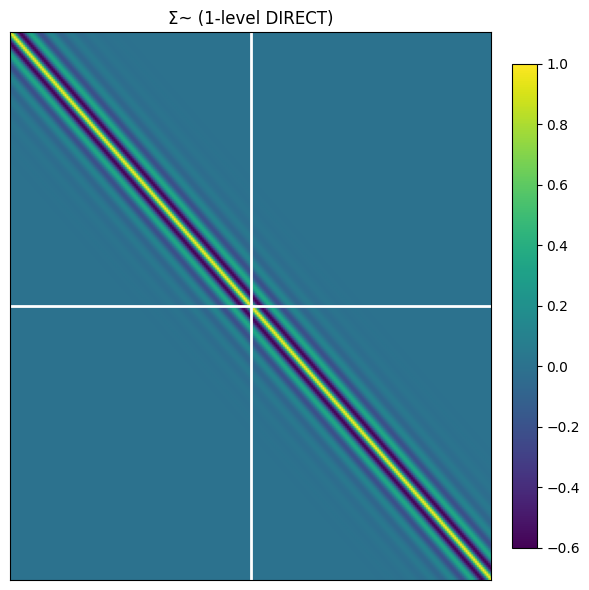

[DIRECT 1L] Frobenius rel. error: 6.75e-17
eig(B): min=1.000000e+00, max=1.000000e+00, span-1=(-7.44e-15,+8.88e-15)
Proxy KL (subblocks): 0.000000e+00


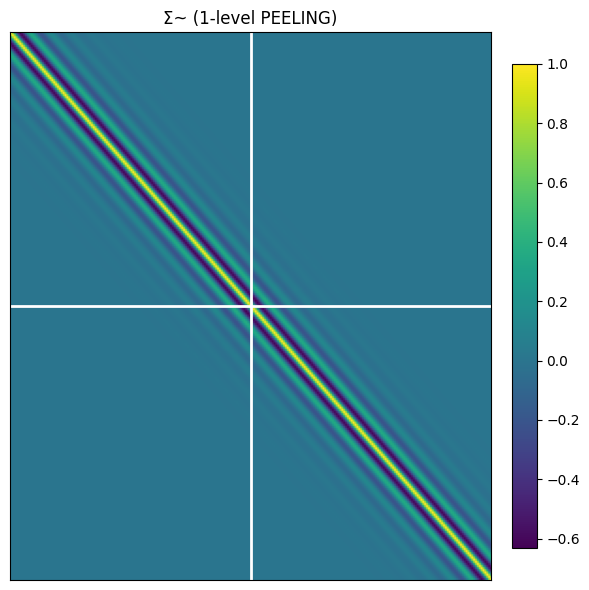

[PEEL 1L] Frobenius rel. error: 6.95e-03
[1L sanity] ||Σ~(direct) - Σ~(peel)||_F / ||Σ~(direct)||_F = 6.95e-03
eig(B): min=6.087229e-01, max=1.151990e+00, span-1=(-3.91e-01,+1.52e-01)
Proxy KL (subblocks): 1.821447e-02


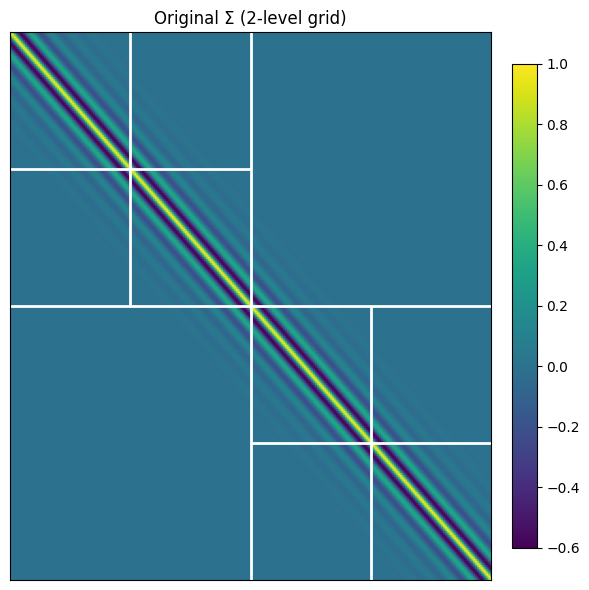

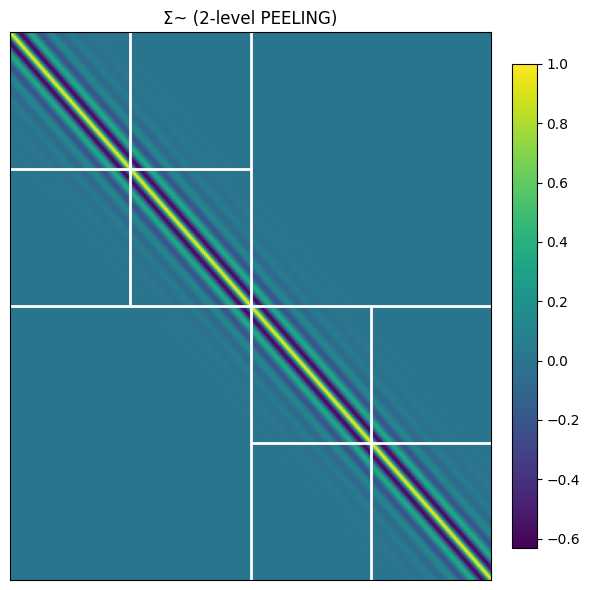

[PEEL 2L] Frobenius rel. error: 9.26e-03
eig(B): min=6.086746e-01, max=1.177309e+00, span-1=(-3.91e-01,+1.77e-01)
Proxy KL (subblocks): 1.851686e-02


In [ ]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# ------- harder kernel (true Sigma) -------
def kernel_osc_exp_1d(n=256, ell=0.04, freq=12.0, nugget=1e-8):
    x = np.linspace(0., 1., n)
    Dx = x[:,None] - x[None,:]
    A = np.exp(-np.abs(Dx)/ell) * np.cos(2*np.pi*freq*Dx)
    A += nugget*np.eye(n)
    return A

# ------- 1-level HODLR build (L|R split) : DIRECT baseline -------
def build_hodlr_1level(A, r=1):
    n = A.shape[0]
    assert n % 2 == 0, "use even n for simple split"
    n2 = n//2
    L = slice(0, n2); R = slice(n2, n)
    A_LL = A[L,L].copy()
    A_RR = A[R,R].copy()

    U, s, Vt = la.svd(A[L,R], full_matrices=False)
    r = min(r, U.shape[1])
    U, s, Vt = U[:, :r], s[:r], Vt[:r, :]

    Atil = np.zeros_like(A)
    Atil[L,L] = A_LL
    Atil[R,R] = A_RR
    Atil[L,R] = U @ (np.diag(s) @ Vt)
    Atil[R,L] = Atil[L,R].T
    return Atil

# ------- plotting helpers: partition lines (your style) -------
def compute_hodlr_leaves(n: int, branching):
    intervals = [(0, n)]
    for b in branching:
        new = []
        for (i0, i1) in intervals:
            length = i1 - i0
            base, rem = divmod(length, b)
            pts = [i0]
            for k in range(b):
                pts.append(pts[-1] + base + (1 if k<rem else 0))
            for k in range(len(pts)-1):
                new.append((pts[k], pts[k+1]))
        intervals = new
    return intervals

def plot_hodlr_partition(A, branching, title="", cmap='viridis', fname=None):
    n = A.shape[0]
    intervals = [(0, n)]
    splits = []
    for b in branching:
        level = []
        new = []
        for (i0, i1) in intervals:
            length = i1 - i0
            base, rem = divmod(length, b)
            pts = [i0]
            for k in range(b):
                pts.append(pts[-1] + base + (1 if k < rem else 0))
            for cut in pts[1:-1]:
                level.append((i0, i1, cut))
            for k in range(len(pts)-1):
                new.append((pts[k], pts[k+1]))
        splits.append(level)
        intervals = new

    leaves = compute_hodlr_leaves(n, branching)
    perm = np.concatenate([np.arange(i0, i1) for i0, i1 in leaves])
    A_perm = A[np.ix_(perm, perm)]

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(A_perm, cmap=cmap, aspect='auto')
    for level in splits:
        for (i0, i1, mid) in level:
            ax.hlines(mid-0.5, i0-0.5, i1-0.5, color='white', lw=2)
            ax.vlines(mid-0.5, i0-0.5, i1-0.5, color='white', lw=2)
    ax.set_title(title if title else f"HODLR Partition (branching={branching})")
    ax.set_xticks([]); ax.set_yticks([])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()

    # --- save at 300 dpi if filename is given ---
    if fname is not None:
        fig.savefig(fname, dpi=300, bbox_inches="tight")

    plt.show()


# ------- proxy-KL on principal subblocks (safe log) -------
def ensure_spd_global(M):
    M = 0.5*(M + M.T)
    try:
        la.cholesky(M, lower=True); return M
    except la.LinAlgError:
        w = la.eigvalsh(M); shift = max(1e-12, -float(w[0]) + 1e-12)
        M = M + shift*np.eye(M.shape[0])
        la.cholesky(M, lower=True)
        return M

def min_eig_and_proxy_KL(A, Atil, s=64, t=10, seed=0, log_eps=1e-12):
    n = A.shape[0]
    Atil = ensure_spd_global(Atil)
    X = la.solve(Atil, A, assume_a='pos')   # B = Σ~^{-1} Σ
    Bs = 0.5*(X + X.T)

    lam = la.eigvalsh(Bs)
    lam_min, lam_max = float(lam[0]), float(lam[-1])
    print(f"eig(B): min={lam_min:.6e}, max={lam_max:.6e}, span-1=({lam_min-1:+.2e},{lam_max-1:+.2e})")

    rng = np.random.default_rng(seed)
    f = lambda x: x - np.log(np.maximum(log_eps, x)) - 1.0
    acc = 0.0
    for _ in range(t):
        S = np.sort(rng.choice(n, size=min(s, n), replace=False))
        BS = Bs[np.ix_(S, S)]
        if not np.allclose(np.diag(BS), np.diag(Bs)[S], atol=1e-12, rtol=1e-9):
            raise RuntimeError("Diagonal of subblock does not match the corresponding diagonal of B.")
        lamS = la.eigvalsh(BS)
        acc += np.sum(f(lamS))
    D_proxy = 0.5 * (n/float(s)) * (acc/float(t))
    print(f"Proxy KL (subblocks): {D_proxy:.6e}")
    return lam_min, D_proxy

# -------------------- rSVD (sketch) --------------------
def _mul_S_left(S, X):
    S = np.asarray(S); X = np.asarray(X)
    if S.ndim==1:
        return S*X if X.ndim==1 else S[:,None]*X
    return S @ X

def randomized_svd_lowrank(apply_A, apply_AT, m, n, rank, oversamp, rng):
    rtot = rank + oversamp
    Omega = rng.standard_normal((n, rtot))
    Y = apply_A(Omega)                    # m x rtot
    Q, _ = la.qr(Y, mode='economic')
    Psi = rng.standard_normal((m, rtot))
    Z = apply_AT(Psi)                     # n x rtot
    P, _ = la.qr(Z, mode='economic')
    B = P.T @ apply_AT(Q)
    Ub, Sb, VbT = la.svd(B, full_matrices=False)
    U  = Q @ Ub[:, :rank]
    S  = Sb[:rank]
    Vt = VbT[:rank, :] @ P.T
    return U, S, Vt

# -------------------- NEW: general peeling (levels = 1 or 2) --------------------
def build_hodlr_peeling(A, levels=1, rank=8, oversamp=4, seed=0):
    """
    Peeling HODLR with levels ∈ {1,2} using only A@v and A@R.
      - levels=1: one L|R split with two leaves.
      - levels=2: two splits (four leaves).
    """
    assert levels in (1,2), "This simple demo supports only 1 or 2 levels."
    rng = np.random.default_rng(seed)
    n = A.shape[0]
    assert n % (2**levels) == 0, "n must be divisible by 2^levels"

    Av = lambda V: A @ V
    Ablock = lambda R: A @ R
    offdiag = {l: [] for l in range(1, levels+1)}
    diag_blocks = []
    stored = []  # (I_L, I_R, U, S, Vt)

    # index sets
    n2 = n//2
    I1 = np.arange(0, n2)   # left half
    I2 = np.arange(n2, n)   # right half
    if levels == 2:
        n4 = n//4
        I11 = np.arange(0, n4)
        I12 = np.arange(n4, n2)
        I21 = np.arange(n2, n2+n4)
        I22 = np.arange(n2+n4, n)

    # helpers for residual application
    def apply_Ghat(X):
        y = np.zeros_like(X) if X.ndim==1 else np.zeros((n, X.shape[1]))
        for (IL, IR, U, S, Vt) in stored:
            XR = X[IR] if X.ndim==1 else X[IR,:]
            if XR.size:
                T = Vt @ XR; T = _mul_S_left(S, T); y[IL] += U @ T
            XL = X[IL] if X.ndim==1 else X[IL,:]
            if XL.size:
                T = U.T @ XL; T = _mul_S_left(S, T); y[IR] += Vt.T @ T
        for (I, D) in diag_blocks:
            XI = X[I] if X.ndim==1 else X[I,:]
            if XI.size: y[I] += D @ XI
        return y

    def apply_residual(X):
        return Ablock(X) - apply_Ghat(X) if X.ndim==2 else Av(X) - apply_Ghat(X)

    # ---- Level 1 off-diagonal ----
    def A_lr_12(X):
        V = np.zeros((n, X.shape[1])); V[I2,:] = X
        W = apply_residual(V); return W[I1,:]
    def AT_lr_12(Y):
        V = np.zeros((n, Y.shape[1])); V[I1,:] = Y
        W = apply_residual(V); return W[I2,:]
    U,S,Vt = randomized_svd_lowrank(A_lr_12, AT_lr_12, m=len(I1), n=len(I2), rank=rank, oversamp=oversamp, rng=rng)
    S = np.asarray(S).ravel()
    stored.append((I1, I2, U, S, Vt))
    offdiag[1].append((I1, I2, U, S, Vt))

    # ---- Level 2 off-diagonals (if requested) ----
    if levels == 2:
        # left siblings I11 vs I12
        def A_lr_L(X):
            V = np.zeros((n, X.shape[1])); V[I12,:] = X
            W = apply_residual(V); return W[I11,:]
        def AT_lr_L(Y):
            V = np.zeros((n, Y.shape[1])); V[I11,:] = Y
            W = apply_residual(V); return W[I12,:]
        U,S,Vt = randomized_svd_lowrank(A_lr_L, AT_lr_L, m=len(I11), n=len(I12), rank=rank, oversamp=oversamp, rng=rng)
        S = np.asarray(S).ravel()
        stored.append((I11, I12, U, S, Vt))
        offdiag[2].append((I11, I12, U, S, Vt))

        # right siblings I21 vs I22
        def A_lr_R(X):
            V = np.zeros((n, X.shape[1])); V[I22,:] = X
            W = apply_residual(V); return W[I21,:]
        def AT_lr_R(Y):
            V = np.zeros((n, Y.shape[1])); V[I21,:] = Y
            W = apply_residual(V); return W[I22,:]
        U,S,Vt = randomized_svd_lowrank(A_lr_R, AT_lr_R, m=len(I21), n=len(I22), rank=rank, oversamp=oversamp, rng=rng)
        S = np.asarray(S).ravel()
        stored.append((I21, I22, U, S, Vt))
        offdiag[2].append((I21, I22, U, S, Vt))

    # ---- Leaf diagonals (2 leaves if L=1; 4 leaves if L=2) ----
    leaves = [I1, I2] if levels==1 else [I11, I12, I21, I22]
    for I in leaves:
        E = np.eye(len(I))
        V = np.zeros((n, len(I))); V[I,:] = E
        Y = apply_residual(V)
        D = 0.5*(Y[I,:] + Y[I,:].T)  # symmetrize
        try:
            la.cholesky(D, lower=True)
        except la.LinAlgError:
            w = la.eigvalsh(D); shift = max(1e-12, -float(w[0]) + 1e-12)
            D += shift*np.eye(D.shape[0])
        diag_blocks.append((I, D))

    return {"levels": levels, "offdiag": offdiag, "diag": diag_blocks, "n": n}

def apply_hodlr_from_factors(factors, X):
    n = factors["n"]
    y = np.zeros_like(X) if X.ndim==1 else np.zeros((n, X.shape[1]))
    for l in range(1, factors["levels"]+1):
        for (I_L, I_R, U, S, Vt) in factors["offdiag"][l]:
            XR = X[I_R] if X.ndim==1 else X[I_R,:]
            if XR.size:
                T = Vt @ XR; T = _mul_S_left(S,T); y[I_L] += U @ T
            XL = X[I_L] if X.ndim==1 else X[I_L,:]
            if XL.size:
                T = U.T @ XL; T = _mul_S_left(S,T); y[I_R] += Vt.T @ T
    for (I, D) in factors["diag"]:
        XI = X[I] if X.ndim==1 else X[I,:]
        if XI.size: y[I] += D @ XI
    return y

# ------------------ demo ------------------
if __name__ == "__main__":
    n = 256
    A   = kernel_osc_exp_1d(n=n, ell=0.04, freq=24.0, nugget=1e-8)

    # (A) Your original 1-level (direct SVD) baseline
    Atil1_direct = build_hodlr_1level(A, r=4)
    branching1 = [2]
    # plot_hodlr_partition(A,            branching1, title="Original Σ (1-level grid)")
    plot_hodlr_partition(Atil1_direct, branching1, title="Σ~ (1-level DIRECT)",
                        fname="hodlr_original_lvl2.png")


    rel_fro1d = la.norm(A - Atil1_direct, 'fro')/la.norm(A, 'fro')
    print(f"[DIRECT 1L] Frobenius rel. error: {rel_fro1d:.2e}")
    lam_min1d, D_proxy1d = min_eig_and_proxy_KL(A, Atil1_direct, s=64, t=10, seed=42)

    # (B) Peeling with levels=1 (sanity check)
    fac1 = build_hodlr_peeling(A, levels=1, rank=4, oversamp=4, seed=0)
    Atil1_peel = apply_hodlr_from_factors(fac1, np.eye(n))
    plot_hodlr_partition(Atil1_peel, branching1, title="Σ~ (1-level PEELING)",
                        fname="hodlr_peel_lvl1.png")

    rel_fro1p = la.norm(A - Atil1_peel, 'fro')/la.norm(A, 'fro')
    diff_1L   = la.norm(Atil1_direct - Atil1_peel, 'fro')/la.norm(Atil1_direct, 'fro')
    print(f"[PEEL 1L] Frobenius rel. error: {rel_fro1p:.2e}")
    print(f"[1L sanity] ||Σ~(direct) - Σ~(peel)||_F / ||Σ~(direct)||_F = {diff_1L:.2e}")
    lam_min1p, D_proxy1p = min_eig_and_proxy_KL(A, Atil1_peel, s=64, t=10, seed=7)

    # (C) Peeling with levels=2 (your earlier request)
    fac2 = build_hodlr_peeling(A, levels=2, rank=4, oversamp=4, seed=0)
    Atil2_peel = apply_hodlr_from_factors(fac2, np.eye(n))
    branching2 = [2, 2]
    plot_hodlr_partition(A,           branching2, title="Original Σ (2-level grid)",
                        fname="hodlr_original_lvl2.png")
    plot_hodlr_partition(Atil2_peel,  branching2, title="Σ~ (2-level PEELING)",
                        fname="hodlr_peel_lvl2.png")

    rel_fro2p = la.norm(A - Atil2_peel, 'fro')/la.norm(A, 'fro')
    print(f"[PEEL 2L] Frobenius rel. error: {rel_fro2p:.2e}")
    lam_min2p, D_proxy2p = min_eig_and_proxy_KL(A, Atil2_peel, s=64, t=10, seed=123)




In [ ]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# ------- harder kernel (true Sigma) -------
def kernel_osc_exp_1d(n=256, ell=0.04, freq=12.0, nugget=1e-8):
    x = np.linspace(0., 1., n)
    Dx = x[:,None] - x[None,:]
    A = np.exp(-np.abs(Dx)/ell) * np.cos(2*np.pi*freq*Dx)
    A += nugget*np.eye(n)
    return A

# ------- 1-level HODLR build (L|R split) : DIRECT baseline -------
def build_hodlr_1level(A, r=1):
    n = A.shape[0]
    assert n % 2 == 0, "use even n for simple split"
    n2 = n//2
    L = slice(0, n2); R = slice(n2, n)
    A_LL = A[L,L].copy()
    A_RR = A[R,R].copy()

    U, s, Vt = la.svd(A[L,R], full_matrices=False)
    r = min(r, U.shape[1])
    U, s, Vt = U[:, :r], s[:r], Vt[:r, :]

    Atil = np.zeros_like(A)
    Atil[L,L] = A_LL
    Atil[R,R] = A_RR
    Atil[L,R] = U @ (np.diag(s) @ Vt)
    Atil[R,L] = Atil[L,R].T
    return Atil

# ------- plotting helpers -------
def compute_hodlr_leaves(n: int, branching):
    intervals = [(0, n)]
    for b in branching:
        new = []
        for (i0, i1) in intervals:
            length = i1 - i0
            base, rem = divmod(length, b)
            pts = [i0]
            for k in range(b):
                pts.append(pts[-1] + base + (1 if k<rem else 0))
            for k in range(len(pts)-1):
                new.append((pts[k], pts[k+1]))
        intervals = new
    return intervals

def plot_hodlr_partition(A, branching, title="", cmap='viridis'):
    n = A.shape[0]
    intervals = [(0, n)]
    splits = []
    for b in branching:
        level = []
        new = []
        for (i0, i1) in intervals:
            length = i1 - i0
            base, rem = divmod(length, b)
            pts = [i0]
            for k in range(b):
                pts.append(pts[-1] + base + (1 if k<rem else 0))
            for cut in pts[1:-1]:
                level.append((i0, i1, cut))
            for k in range(len(pts)-1):
                new.append((pts[k], pts[k+1]))
        splits.append(level)
        intervals = new

    leaves = compute_hodlr_leaves(n, branching)
    perm = np.concatenate([np.arange(i0, i1) for i0, i1 in leaves])
    A_perm = A[np.ix_(perm, perm)]

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(A_perm, cmap=cmap, aspect='auto')
    for level in splits:
        for (i0,i1,mid) in level:
            ax.hlines(mid-0.5, i0-0.5, i1-0.5, color='white', lw=2)
            ax.vlines(mid-0.5, i0-0.5, i1-0.5, color='white', lw=2)
    ax.set_title(title if title else f"HODLR Partition (branching={branching})")
    ax.set_xticks([]); ax.set_yticks([])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# ------- proxy-KL on principal subblocks -------
def ensure_spd_global(M):
    M = 0.5*(M + M.T)
    try:
        la.cholesky(M, lower=True); return M
    except la.LinAlgError:
        w = la.eigvalsh(M); shift = max(1e-12, -float(w[0]) + 1e-12)
        M = M + shift*np.eye(M.shape[0])
        la.cholesky(M, lower=True)
        return M

def min_eig_and_proxy_KL(A, Atil, s=64, t=10, seed=0, log_eps=1e-12):
    n = A.shape[0]
    Atil = ensure_spd_global(Atil)
    X = la.solve(Atil, A, assume_a='pos')
    Bs = 0.5*(X + X.T)

    lam = la.eigvalsh(Bs)
    lam_min, lam_max = float(lam[0]), float(lam[-1])
    print(f"eig(B): min={lam_min:.6e}, max={lam_max:.6e}, span-1=({lam_min-1:+.2e},{lam_max-1:+.2e})")

    rng = np.random.default_rng(seed)
    f = lambda x: x - np.log(np.maximum(log_eps, x)) - 1.0
    acc = 0.0
    for _ in range(t):
        S = np.sort(rng.choice(n, size=min(s, n), replace=False))
        BS = Bs[np.ix_(S, S)]
        lamS = la.eigvalsh(BS)
        acc += np.sum(f(lamS))
    D_proxy = 0.5 * (n/float(s)) * (acc/float(t))
    print(f"Proxy KL (subblocks): {D_proxy:.6e}")
    return lam_min, D_proxy

# ------- direct KL via logdet -------
def direct_KL(Sigma, Sigma_tilde):
    n = Sigma.shape[0]
    Sigma_tilde = ensure_spd_global(Sigma_tilde)
    X = la.solve(Sigma_tilde, Sigma, assume_a='pos')
    tr_term = np.trace(X)
    sign1, logdet1 = np.linalg.slogdet(Sigma_tilde)
    sign2, logdet2 = np.linalg.slogdet(Sigma)
    if sign1 <= 0 or sign2 <= 0:
        raise ValueError("Non-SPD matrix in logdet")
    logdet_term = logdet1 - logdet2
    KL = 0.5 * (tr_term - n + logdet_term)
    return KL

# -------------------- rSVD (for peeling) --------------------
def _mul_S_left(S, X):
    S = np.asarray(S); X = np.asarray(X)
    if S.ndim==1:
        return S*X if X.ndim==1 else S[:,None]*X
    return S @ X

def randomized_svd_lowrank(apply_A, apply_AT, m, n, rank, oversamp, rng):
    rtot = rank + oversamp
    Omega = rng.standard_normal((n, rtot))
    Y = apply_A(Omega)
    Q, _ = la.qr(Y, mode='economic')
    Psi = rng.standard_normal((m, rtot))
    Z = apply_AT(Psi)
    P, _ = la.qr(Z, mode='economic')
    B = P.T @ apply_AT(Q)
    Ub, Sb, VbT = la.svd(B, full_matrices=False)
    U  = Q @ Ub[:, :rank]
    S  = Sb[:rank]
    Vt = VbT[:rank, :] @ P.T
    return U, S, Vt

# -------------------- Peeling --------------------
def build_hodlr_peeling(A, levels=1, rank=8, oversamp=4, seed=0):
    assert levels in (1,2), "Supports only 1 or 2 levels"
    rng = np.random.default_rng(seed)
    n = A.shape[0]
    assert n % (2**levels) == 0

    Av = lambda V: A @ V
    offdiag = {l: [] for l in range(1, levels+1)}
    diag_blocks = []
    stored = []

    n2 = n//2
    I1 = np.arange(0, n2)
    I2 = np.arange(n2, n)
    if levels == 2:
        n4 = n//4
        I11 = np.arange(0, n4)
        I12 = np.arange(n4, n2)
        I21 = np.arange(n2, n2+n4)
        I22 = np.arange(n2+n4, n)

    def apply_Ghat(X):
        y = np.zeros_like(X) if X.ndim==1 else np.zeros((n, X.shape[1]))
        for (IL, IR, U, S, Vt) in stored:
            XR = X[IR] if X.ndim==1 else X[IR,:]
            if XR.size:
                T = Vt @ XR; T = _mul_S_left(S,T); y[IL] += U @ T
            XL = X[IL] if X.ndim==1 else X[IL,:]
            if XL.size:
                T = U.T @ XL; T = _mul_S_left(S,T); y[IR] += Vt.T @ T
        for (I, D) in diag_blocks:
            XI = X[I] if X.ndim==1 else X[I,:]
            if XI.size: y[I] += D @ XI
        return y

    def apply_residual(X):
        return Av(X) - apply_Ghat(X)

    # Level 1
    def A_lr_12(X):
        V = np.zeros((n, X.shape[1])); V[I2,:] = X
        W = apply_residual(V); return W[I1,:]
    def AT_lr_12(Y):
        V = np.zeros((n, Y.shape[1])); V[I1,:] = Y
        W = apply_residual(V); return W[I2,:]
    U,S,Vt = randomized_svd_lowrank(A_lr_12, AT_lr_12, len(I1), len(I2), rank, oversamp, rng)
    S = np.asarray(S).ravel()
    stored.append((I1, I2, U, S, Vt))
    offdiag[1].append((I1, I2, U, S, Vt))

    if levels == 2:
        # Left siblings
        def A_lr_L(X):
            V = np.zeros((n, X.shape[1])); V[I12,:] = X
            W = apply_residual(V); return W[I11,:]
        def AT_lr_L(Y):
            V = np.zeros((n, Y.shape[1])); V[I11,:] = Y
            W = apply_residual(V); return W[I12,:]
        U,S,Vt = randomized_svd_lowrank(A_lr_L, AT_lr_L, len(I11), len(I12), rank, oversamp, rng)
        S = np.asarray(S).ravel()
        stored.append((I11, I12, U, S, Vt))
        offdiag[2].append((I11, I12, U, S, Vt))
        # Right siblings
        def A_lr_R(X):
            V = np.zeros((n, X.shape[1])); V[I22,:] = X
            W = apply_residual(V); return W[I21,:]
        def AT_lr_R(Y):
            V = np.zeros((n, Y.shape[1])); V[I21,:] = Y
            W = apply_residual(V); return W[I22,:]
        U,S,Vt = randomized_svd_lowrank(A_lr_R, AT_lr_R, len(I21), len(I22), rank, oversamp, rng)
        S = np.asarray(S).ravel()
        stored.append((I21, I22, U, S, Vt))
        offdiag[2].append((I21, I22, U, S, Vt))

    leaves = [I1, I2] if levels==1 else [I11, I12, I21, I22]
    for I in leaves:
        E = np.eye(len(I))
        V = np.zeros((n, len(I))); V[I,:] = E
        Y = apply_residual(V)
        D = 0.5*(Y[I,:] + Y[I,:].T)
        try:
            la.cholesky(D, lower=True)
        except la.LinAlgError:
            w = la.eigvalsh(D); shift = max(1e-12, -float(w[0]) + 1e-12)
            D += shift*np.eye(D.shape[0])
        diag_blocks.append((I, D))

    return {"levels": levels, "offdiag": offdiag, "diag": diag_blocks, "n": n}

def apply_hodlr_from_factors(factors, X):
    n = factors["n"]
    y = np.zeros_like(X) if X.ndim==1 else np.zeros((n, X.shape[1]))
    for l in range(1, factors["levels"]+1):
        for (I_L, I_R, U, S, Vt) in factors["offdiag"][l]:
            XR = X[I_R] if X.ndim==1 else X[I_R,:]
            if XR.size:
                T = Vt @ XR; T = _mul_S_left(S,T); y[I_L] += U @ T
            XL = X[I_L] if X.ndim==1 else X[I_L,:]
            if XL.size:
                T = U.T @ XL; T = _mul_S_left(S,T); y[I_R] += Vt.T @ T
    for (I, D) in factors["diag"]:
        XI = X[I] if X.ndim==1 else X[I,:]
        if XI.size: y[I] += D @ XI
    return y

# ------------------ demo ------------------
if __name__ == "__main__":
    n = 256
    A   = kernel_osc_exp_1d(n=n, ell=0.04, freq=24.0, nugget=1e-8)

    # --- 1-level DIRECT ---
    Atil1_direct = build_hodlr_1level(A, r=4)
    rel_fro1d = la.norm(A - Atil1_direct, 'fro')/la.norm(A, 'fro')
    lam_min1d, D_proxy1d = min_eig_and_proxy_KL(A, Atil1_direct, s=64, t=10, seed=42)
    KL1d = direct_KL(A, Atil1_direct)
    print(f"[DIRECT 1L] Frobenius rel. error={rel_fro1d:.2e}, Proxy KL={D_proxy1d:.2e}, Direct KL={KL1d:.2e}")

    # --- 1-level PEELING ---
    fac1 = build_hodlr_peeling(A, levels=1, rank=4, oversamp=4, seed=0)
    Atil1_peel = apply_hodlr_from_factors(fac1, np.eye(n))
    rel_fro1p = la.norm(A - Atil1_peel, 'fro')/la.norm(A, 'fro')
    lam_min1p, D_proxy1p = min_eig_and_proxy_KL(A, Atil1_peel, s=64, t=10, seed=7)
    KL1p = direct_KL(A, Atil1_peel)
    print(f"[PEEL 1L] Frobenius rel. error={rel_fro1p:.2e}, Proxy KL={D_proxy1p:.2e}, Direct KL={KL1p:.2e}")

    # --- 2-level PEELING ---
    fac2 = build_hodlr_peeling(A, levels=2, rank=4, oversamp=4, seed=0)
    Atil2_peel = apply_hodlr_from_factors(fac2, np.eye(n))
    rel_fro2p = la.norm(A - Atil2_peel, 'fro')/la.norm(A, 'fro')
    lam_min2p, D_proxy2p = min_eig_and_proxy_KL(A, Atil2_peel, s=64, t=10, seed=123)
    KL2p = direct_KL(A, Atil2_peel)
    print(f"[PEEL 2L] Frobenius rel. error={rel_fro2p:.2e}, Proxy KL={D_proxy2p:.2e}, Direct KL={KL2p:.2e}")


eig(B): min=1.000000e+00, max=1.000000e+00, span-1=(-8.10e-15,+7.77e-15)
Proxy KL (subblocks): 0.000000e+00
[DIRECT 1L] Frobenius rel. error=6.97e-17, Proxy KL=0.00e+00, Direct KL=5.68e-14
eig(B): min=6.087229e-01, max=1.151990e+00, span-1=(-3.91e-01,+1.52e-01)
Proxy KL (subblocks): 1.821447e-02
[PEEL 1L] Frobenius rel. error=6.95e-03, Proxy KL=1.82e-02, Direct KL=2.46e-02
eig(B): min=6.086746e-01, max=1.177309e+00, span-1=(-3.91e-01,+1.77e-01)
Proxy KL (subblocks): 1.851686e-02
[PEEL 2L] Frobenius rel. error=9.26e-03, Proxy KL=1.85e-02, Direct KL=4.28e-02


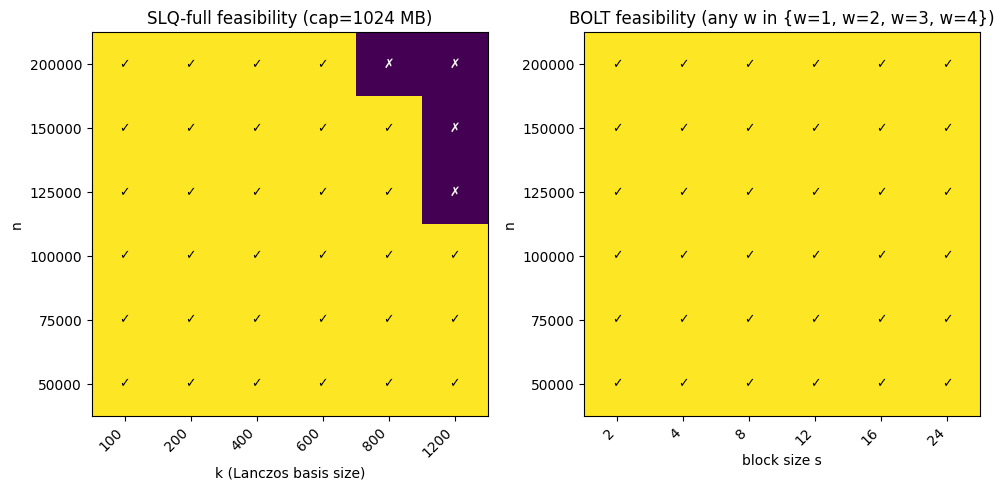

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------- knobs ----------
CAP_MB = 1024                              # 1 GB cap
DTYPE_BYTES = 8                            # float64
n_grid      = np.array([50_000, 75_000, 100_000, 125_000, 150_000, 200_000])
k_grid      = np.array([100, 200, 400, 600, 800, 1200])              # SLQ-full basis size
# s_grid      = np.array([100, 200, 400, 600, 800, 1200])              # BOLT block size
s_grid      = np.array([2, 4, 8, 12, 16, 24])                        # BOLT block size
w_grid      = np.array([1, 2, 3, 4])                                 # BOLT window
probes_grid = np.array([32, 64, 128, 256, 512, 1024])                # Hutch++ probes

# --------- memory models (bytes) ----------
def mem_slq_full(n, k):
    return DTYPE_BYTES * (n * k + 5*n + 10*k)  # Q plus small work
def mem_bolt(n, s, w):
    return DTYPE_BYTES * (n * s * w + 6*n + 10*s*w)  # windowed block basis + work
def mem_hutchpp(n, probes):
    hold = min(probes, 8)  # streaming; cache only a handful of sketches
    return DTYPE_BYTES * (n * (4 + hold) + 10*probes)

def to_mb(x): return x / (1024**2)

# --------- feasibility tables ----------
def feas_table_slq(n_vals, k_vals, cap_mb):
    F = np.zeros((len(n_vals), len(k_vals)), dtype=int)
    for i, n in enumerate(n_vals):
        for j, k in enumerate(k_vals):
            F[i, j] = int(to_mb(mem_slq_full(n, k)) <= cap_mb)
    return F

def feas_table_bolt(n_vals, s_vals, w, cap_mb):
    F = np.zeros((len(n_vals), len(s_vals)), dtype=int)
    for i, n in enumerate(n_vals):
        for j, s in enumerate(s_vals):
            F[i, j] = int(to_mb(mem_bolt(n, s, w)) <= cap_mb)
    return F

def feas_table_hutch(n_vals, p_vals, cap_mb):
    F = np.zeros((len(n_vals), len(p_vals)), dtype=int)
    for i, n in enumerate(n_vals):
        for j, p in enumerate(p_vals):
            F[i, j] = int(to_mb(mem_hutchpp(n, p)) <= cap_mb)
    return F

# choose a representative BOLT window for the panel; we’ll annotate multiple w in the title
BOLT_WINDOWS_FOR_PLOT = [1, 2, 3, 4]

# --------- plotting ----------
def plot_panel(ax, F, x_ticks, y_ticks, title, xlabel, ylabel):
    im = ax.imshow(F, origin="lower", aspect="auto", vmin=0, vmax=1)
    ax.set_xticks(np.arange(len(x_ticks)))
    ax.set_xticklabels([str(x) for x in x_ticks], rotation=45, ha='right')
    ax.set_yticks(np.arange(len(y_ticks)))
    ax.set_yticklabels([str(y) for y in y_ticks])
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
    # overlay ✓/✗
    for i in range(F.shape[0]):
        for j in range(F.shape[1]):
            ax.text(j, i, "✓" if F[i, j] else "✗",
                    ha="center", va="center", fontsize=9, color="white" if F[i,j]==0 else "black")

def main():
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # SLQ-full: n vs k
    F_slq = feas_table_slq(n_grid, k_grid, CAP_MB)
    plot_panel(axs[0], F_slq, k_grid, n_grid,
               f"SLQ-full feasibility (cap={CAP_MB} MB)",
               "k (Lanczos basis size)", "n")

    # BOLT: n vs s for each w; collapse by marking entry feasible if ANY w in set is feasible
    F_bolt_any = np.zeros((len(n_grid), len(s_grid)), dtype=int)
    legends = []
    for w in BOLT_WINDOWS_FOR_PLOT:
        Fb = feas_table_bolt(n_grid, s_grid, w, CAP_MB)
        F_bolt_any |= Fb
        legends.append(f"w={w}")
    plot_panel(axs[1], F_bolt_any, s_grid, n_grid,
               f"BOLT feasibility (any w in {{{', '.join(legends)}}})",
               "block size s", "n")


    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


# Plot on max memeory usage vs block size vs work with full matrices (logdet) (memory usage)

Building kernel A (n=16,000) ...
BOLT (b=2) [############################] 20/20    1.7s
BOLT (b=4) [############################] 20/20    1.7s
BOLT (b=8) [############################] 20/20    2.4s
BOLT (b=12) [############################] 20/20    3.0s
BOLT (b=16) [############################] 20/20    3.1s
BOLT (b=24) [############################] 20/20    4.6s
BOLT (b=32) [############################] 20/20    5.7s
BOLT (b=48) [############################] 20/20    8.1s
BOLT (b=64) [############################] 20/20    9.5s
BOLT (b=96) [############################] 20/20   11.3s
BOLT (b=128) [############################] 20/20   13.2s

[slogdet] logdet=-9.218339e+04, peak≈3906.2 MB
[BOLT] b=   2 | rel.err=4.35e-01 | peak≈1953.9 MB
[BOLT] b=   4 | rel.err=2.09e+00 | peak≈1954.6 MB
[BOLT] b=   8 | rel.err=1.45e+00 | peak≈1956.1 MB
[BOLT] b=  12 | rel.err=1.54e+00 | peak≈1957.5 MB
[BOLT] b=  16 | rel.err=1.46e+00 | peak≈1959.0 MB
[BOLT] b=  24 | rel.err=1.13e+00 | peak≈1961

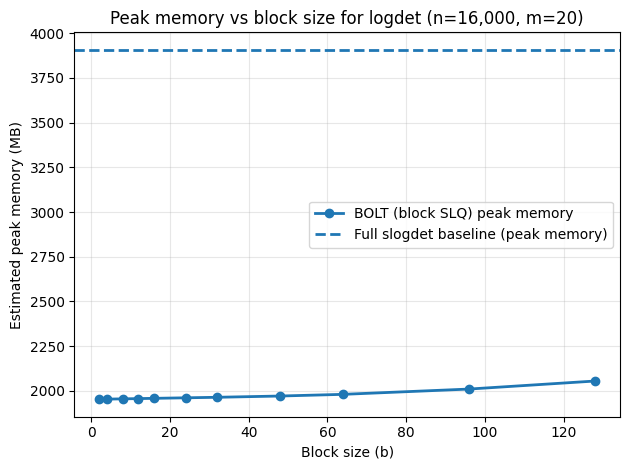

In [ ]:
# --- Same setup (n=16000) + BOLT vs slogdet peak-memory plot ---

import numpy as np
import time, sys

# ---- use SciPy if available, else NumPy ----
try:
    import scipy.linalg as la
except Exception:
    import numpy.linalg as la

import matplotlib.pyplot as plt

# ---------------- Progress helpers (unchanged) ----------------
class Progress:
    def __init__(self, total, desc=""):
        self.total = max(1, int(total))
        self.count = 0
        self.desc = desc
        self.start = time.time()
        self._render()
    def step(self, inc=1):
        self.count = min(self.total, self.count + inc)
        self._render()
        if self.count >= self.total:
            sys.stdout.write("\n"); sys.stdout.flush()
    def _render(self):
        width = 28
        done = int(width * self.count / self.total)
        bar = "#"*done + "-"*(width-done)
        elapsed = time.time() - self.start
        sys.stdout.write(f"\r{self.desc} [{bar}] {self.count}/{self.total}  {elapsed:5.1f}s")
        sys.stdout.flush()

def estimate_direct_kl_mem_gb(n, arrays=6):
    return arrays * (8.0 * n * n) / 1e9

# -------------- Kernels & utilities (unchanged) --------------
def kernel_osc_exp_1d(n=256, ell=0.04, freq=12.0, nugget=1e-8):
    x = np.linspace(0., 1., n)
    Dx = x[:,None] - x[None,:]
    A = np.exp(-np.abs(Dx)/ell) * np.cos(2*np.pi*freq*Dx)
    A += nugget*np.eye(n)
    return A

def ensure_spd_global(M):
    M = 0.5*(M + M.T)
    try:
        la.cholesky(M)
        return M
    except Exception:
        w = la.eigvalsh(M); shift = max(1e-12, -float(w[0]) + 1e-12)
        M = M + shift*np.eye(M.shape[0])
        la.cholesky(M)
        return M

# ---------------- BOLT (block SLQ) logdet with progress ----------------
def bolt_logdet_peakmem(A, b=16, m=20, seed=0, log_eps=1e-15, show_progress=True):
    """
    Block Lanczos / SLQ estimator for logdet(A).
    Returns (logdet_estimate, peak_bytes_estimate).
    Peak memory = bytes of dense A plus live NumPy arrays we control.
    """
    rng = np.random.default_rng(seed)
    n = A.shape[0]
    base = int(np.asarray(A).nbytes)  # count storing A

    # start block (orthonormal)
    Z = rng.standard_normal((n, b))
    Q, R = la.qr(Z, mode='economic')
    W = (R @ R.T) / float(b)  # weight for block start
    bytes_live = lambda objs: base + sum(0 if x is None else int(np.asarray(x).nbytes) for x in objs)

    peak = bytes_live([Q, R, W])
    Q_prev = None
    As, Bs = [], []

    pb = Progress(m, desc=f"BOLT (b={b})") if show_progress else None
    for j in range(m):
        V = A @ Q                       # (n x b)
        A_j = Q.T @ V                   # (b x b)
        A_j = 0.5*(A_j + A_j.T)
        V = V - Q @ A_j
        if Q_prev is not None:
            V = V - Q_prev @ Bs[-1].T
        Q_next, Rj = la.qr(V, mode='economic')
        As.append(A_j)
        if j < m-1:
            Bs.append(Rj)
        peak = max(peak, bytes_live([Q_prev, Q, V, W]))
        Q_prev, Q = Q, Q_next
        if pb: pb.step()

    # assemble T (mb x mb) and compute E1^T log(T) E1
    mb = m*b
    T = np.zeros((mb, mb))
    for j in range(m):
        sl = slice(j*b, (j+1)*b)
        T[sl, sl] = As[j]
        if j < m-1:
            sr = slice((j+1)*b, (j+2)*b)
            T[sl, sr] = Bs[j]
            T[sr, sl] = Bs[j].T
    peak = max(peak, bytes_live([Q, Q_prev, T, W]))

    evals, evecs = la.eigh(T)
    evals = np.maximum(evals, log_eps)
    Utop = evecs[:b, :]                    # selector E1^T
    ftheta = np.log(evals)
    M = (Utop * ftheta) @ Utop.T           # E1^T f(T) E1
    logdet_est = float(np.trace(W @ M))
    peak = max(peak, bytes_live([T, evecs, Utop, W]))
    return logdet_est, peak

# ---------------- slogdet baseline (peak mem) ----------------
def slogdet_with_mem(A):
    # Dense factorization often induces at least ~2x A storage footprint.
    mem_bytes = int(np.asarray(A).nbytes) * 2
    sign, logdet = np.linalg.slogdet(A)
    if sign <= 0:
        raise ValueError("Matrix not SPD for slogdet.")
    return float(logdet), mem_bytes

# ---------------- Run (n=16000) & Plot ----------------
if __name__ == "__main__":
    n = 16000
    print(f"Building kernel A (n={n:,}) ...")
    A = ensure_spd_global(kernel_osc_exp_1d(n=n, ell=0.04, freq=24.0, nugget=1e-8))

    # BOLT settings
    m_steps    = 20
    block_grid = [2, 4, 8, 12, 16, 24, 32, 48, 64, 96, 128]

    bolt_mem_MB, bolt_logd = [], []
    for b in block_grid:
        est, peak = bolt_logdet_peakmem(A, b=b, m=m_steps, seed=0, show_progress=True)
        bolt_logd.append(est)
        bolt_mem_MB.append(peak / (1024**2))

    logd_exact, slogdet_mem = slogdet_with_mem(A)
    slogdet_mem_MB = slogdet_mem / (1024**2)

    # summary
    errs = [abs(x - logd_exact)/max(1.0, abs(logd_exact)) for x in bolt_logd]
    print(f"\n[slogdet] logdet={logd_exact:.6e}, peak≈{slogdet_mem_MB:.1f} MB")
    for b, e, mem in zip(block_grid, errs, bolt_mem_MB):
        print(f"[BOLT] b={b:>4} | rel.err={e:.2e} | peak≈{mem:.1f} MB")

    # ---- Same plot as before: peak memory vs block size ----
    plt.plot(block_grid, bolt_mem_MB, marker='o', linewidth=2, label="BOLT (block SLQ) peak memory")
    plt.axhline(y=slogdet_mem_MB, linestyle="--", linewidth=2, label="Full slogdet baseline (peak memory)")
    plt.xlabel("Block size (b)")
    plt.ylabel("Estimated peak memory (MB)")
    plt.title(f"Peak memory vs block size for logdet (n={n:,}, m={m_steps})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('memeory_plot.png', dpi=300)
    plt.show()
